In [1]:
from sys import executable as python

In [2]:
!{python} -m pip install -q -q -U pip tqdm scikit-learn pandas sparsesvd plotly pandas matplotlib nbformat psutil jinja2

# install plotting dependencies
# !wget -q https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get -qq install xvfb libgtk2.0-0 libgconf-2-4

In [1]:
import datetime, os, random, shutil, urllib.request, zipfile, time, warnings
warnings.filterwarnings('ignore')
from functools import wraps
from math import trunc
from itertools import product
import numpy as np
import pandas as pd
from pathlib import Path
from urllib.request import urlopen
from zipfile import ZipFile
from scipy.sparse.linalg import norm
import scipy.sparse as ss
from scipy.sparse.linalg import svds
from sparsesvd import sparsesvd
from sklearn.metrics import mean_squared_error as mse
import plotly.express as px
import json
from sys import stdout
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display

from tqdm import tqdm

SEED = 123
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()

def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

# Preprocessing

In [2]:
def get_dataset():
    path = Path("m1.zip")
    if not path.exists():
        with path.open("wb") as f:
            print("Downloading dataset...")
            f.write(urlopen("http://files.grouplens.org/datasets/movielens/ml-1m.zip").read())
    if not Path("ml-1m").is_dir():
        print("unzipping...")
        with ZipFile("m1.zip") as zf:
            zf.extractall()
    ratings_list = [i.strip().split("::") for i in open('ml-1m/ratings.dat', 'r').readlines()]
    ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
    ratings_df['Rating'] = ratings_df['Rating'].apply(pd.to_numeric)
    return ratings_df

In [3]:
def split(df, test_size=2500, validation_size=2500):
    R_df = df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
    seed_everything()
    test_indices = np.array(random.sample(list(np.argwhere(R_df.values>0)), test_size))

    x_indices = test_indices[:,0]
    y_indices = test_indices[:,1]
    u_ids = R_df.index[x_indices].astype(np.int32)
    i_ids = R_df.columns[y_indices].astype(np.int32)
    
    df['UserID'] = df['UserID'].astype(np.int32)
    df['MovieID'] = df['MovieID'].astype(np.int32)
    df['Rating'] = df['Rating'].astype(np.float64)
    
    df= df.drop(columns=['Timestamp'], errors='ignore')
    
    test = []
    for u_id, i_id in zip(u_ids, i_ids):
        test.append(df.loc[(df['UserID'] == u_id) & (df['MovieID'] == i_id)])
    test_df = pd.concat(test)
    train_df= df.drop(test_df.index.tolist())
    
    matrix_only_with_test = np.zeros(R_df.shape, dtype=np.float64) 
    matrix_only_with_test[x_indices, y_indices] =  R_df.values[x_indices, y_indices]
    M_test_df = pd.DataFrame(matrix_only_with_test, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    matrix_without_test = R_df.copy().values
    matrix_without_test[x_indices,y_indices] = 0.0
    M_train_df = pd.DataFrame(matrix_without_test, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    
    validation_indices = np.array(random.sample(list(np.argwhere(M_train_df.values>0)), validation_size))

    x_indices = validation_indices[:,0]
    y_indices = validation_indices[:,1]
    u_ids = R_df.index[x_indices].astype(np.int32)
    i_ids = R_df.columns[y_indices].astype(np.int32)
    
    df= df.drop(columns=['Timestamp'], errors='ignore')
    
    validation = []
    for u_id, i_id in zip(u_ids, i_ids):
        validation.append(df.loc[(df['UserID'] == u_id) & (df['MovieID'] == i_id)])
    validation_df = pd.concat(validation)
    train_df= train_df.drop(validation_df.index.tolist())
    
    matrix_only_with_validation = np.zeros(R_df.shape, dtype=np.float64) 
    matrix_only_with_validation[x_indices, y_indices] =  R_df.values[x_indices, y_indices]
    M_validation_df = pd.DataFrame(matrix_only_with_validation, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    matrix_with_train = R_df.copy().values
    matrix_with_train[test_indices[:,0],test_indices[:,1]] = 0.0
    matrix_with_train[validation_indices[:,0],validation_indices[:,1]] = 0.0
    
    M_train_df = pd.DataFrame(matrix_with_train, index=R_df.index.astype(np.int32), columns=R_df.columns.astype(np.int32))
    
    return train_df, test_df,validation_df, M_train_df, M_test_df, M_validation_df

In [4]:
ratings_df = get_dataset()
train_df, test_df,validation_df, M_train_df, M_test_df, M_validation_df = split(ratings_df)

In [5]:
test_df.head()

,UserID,MovieID,Rating
206405,1265,1732,4.0
409183,2456,2105,3.0
240650,1449,2959,4.0
886005,5350,2640,2.0
540360,3323,3468,4.0


In [6]:
M_train_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




# Funk-SVD

In [16]:
class FunkSVD:
    def __init__(self, lr=.005, reg=.02, n_epochs=20, n_factors=100,
                 min_delta=.001,
                 min_rating=1, max_rating=5):

        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.min_rating = min_rating
        self.max_rating = max_rating

    def fit(self, X, X_test):
        X = self._preprocess_data(X)

        
        X_test = self._preprocess_data(X_test, train=False)
        self._init_metrics()
        self.global_mean_ = np.mean(X[:, 2])
        return self._run_sgd(X, X_test)

    def _preprocess_data(self, X, train=True):
        X = X.copy()
        if train:  # Mappings have to be created
            #assumed that train data includes all possible users and movies (not necessarily ratings)
            user_ids = X['UserID'].unique().tolist()
            item_ids = X['MovieID'].unique().tolist()
            n_users = len(user_ids)
            n_items = len(item_ids)
            user_idx = range(n_users)
            item_idx = range(n_items)
            self.user_mapping_ = dict(zip(user_ids, user_idx))
            self.item_mapping_ = dict(zip(item_ids, item_idx))
        X['UserID'] = X['UserID'].map(self.user_mapping_)
        X['MovieID'] = X['MovieID'].map(self.item_mapping_)
        
        X['UserID'] = X['UserID'].astype(np.int32)
        X['MovieID'] = X['MovieID'].astype(np.int32)
        return X[['UserID', 'MovieID', 'Rating']].values

    def _init_metrics(self):
        metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
        self.metrics_ = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])

    def _run_sgd(self, X, X_test):
        reg,lr,global_mean,n_factors = self.reg,self.lr,self.global_mean_,self.n_factors
        
        n_users = len(np.unique(X[:, 0]))
        n_items = len(np.unique(X[:, 1]))
        bu = np.zeros(n_users)
        bi = np.zeros(n_items)
        pu = np.random.normal(0, .1, (n_users, n_factors))
        qi = np.random.normal(0, .1, (n_items, n_factors))
        
        indices = (X_test[:,0].astype(int), X_test[:,1].astype(int))
        true = X_test[:,2]
        
        # Run SGD
        pbar = tqdm(range(self.n_epochs), desc='Epoch', ncols=110, position=0, leave=True)
    
        #stochastic sgd
        for epoch_ix in pbar:
            
            #with batch size 1
            for row in X:
                user, item, rating = int(row[0]), int(row[1]), row[2]

                pred= np.dot(pu[user,:], qi[item,:])+ global_mean + bu[user]+bi[item]
                err = rating - pred

                # Update biases
                bu[user] += lr * (err - reg * bu[user])
                bi[item] += lr * (err - reg * bi[item])

                # Update latent factors
                pu_update= lr * (err * qi[item, :] - reg * pu[user, :])
                qi_update= lr * (err * pu[user, :] - reg * qi[item, :])
                pu[user, :] = pu[user, :] + pu_update
                qi[item, :] = qi[item, :] + qi_update
            
            #compute test error
            pred = global_mean + np.matmul(pu, qi.T) + bu.reshape(-1, 1) + bi.reshape(1, -1)
            pred = np.clip(pred, self.min_rating, self.max_rating)
            residual = (pred[indices] - true).ravel()
            mse_score = np.square(residual).mean()
            rmse_score = rmse(true, pred[indices])
            mae_score = np.absolute(residual).mean()

            #save results in df
            self.metrics_.loc[epoch_ix, :] = (mse_score, rmse_score, mae_score)
            f = lambda x: f"{self.metrics_.loc[epoch_ix, x]:.3f}"
            pbar.set_postfix({f'test_{m}': f(m) for m in self.metrics_.columns})

        self.bu_, self.bi_, self.pu_, self.qi_ = bu, bi, pu, qi
        return {f"test_{m}": np.trim_zeros(self.metrics_[m]).tolist() for m in self.metrics_.columns}

    def predict(self, X):
        return [
            self.predict_pair(u_id, i_id)
            for u_id, i_id in zip(X['UserID'], X['MovieID'])
        ]

    def predict_pair(self, u_id, i_id):
        assert u_id in self.user_mapping_ and i_id in self.item_mapping_, f"user {u_id} or movie {i_id} not in train data"
        
        i_ix = self.item_mapping_[i_id]
        u_ix = self.user_mapping_[u_id]
        pred = self.global_mean_ + self.bi_[i_ix] + self.bu_[u_ix] + np.dot(self.pu_[u_ix], self.qi_[i_ix])
        pred = np.clip(pred, self.min_rating, self.max_rating)
        return pred

In [17]:
class SVT:
    def __init__(self, tau, delta, n_epochs, min_rating=1, max_rating=5):
        self.tau = tau
        self.delta = delta
        self.n_epochs = n_epochs
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.tol = 0.001
        self.increment = 5
    
    def _init_metrics(self):
        metrics = np.zeros((self.n_epochs, 3), dtype=np.float)
        self.metrics_ = pd.DataFrame(metrics, columns=['Loss', 'RMSE', 'MAE'])
    
    def fit(self, M, M_test):
        ### preprocessing -->
        
        self._init_metrics()
        M = M.copy()
        M_test = M_test.copy()
        
        self.user_mapping_ = dict(zip(M.index, range(len(M.index))))
        self.item_mapping_ = dict(zip(M.columns, range(len(M.columns))))
        self.users_mean = np.mean(M.values, axis = 1).reshape(-1, 1)
        
        M = M.values
        M_test= M_test.values
        
        
        Omega = M.astype(np.int32).nonzero()
        test_indices= M_test.astype(np.int32).nonzero()
        
        M = M- self.users_mean
        M_test= M_test - self.users_mean
        
        test_true = M_test[test_indices].ravel()
        
        tol = self.tol
        incre = self.increment
        tau = self.tau
        iterations= self.n_epochs
        delta = self.delta
        ### --> preprocessing

        # SVT
        r = 0
        P_Omega_M = ss.csr_matrix((np.ravel(M[Omega]), Omega), shape=M.shape)
        normProjM = norm(P_Omega_M)
        k0 = np.ceil(tau / (delta * normProjM))
        Y = k0 * delta * P_Omega_M

        pbar = tqdm(range(iterations), position=0, leave=True, desc='Iteration', ncols=110)

        for epoch_ix in pbar:
            s = r + 1
            sparse_Y = ss.csc_matrix(Y)
            
            #find s largest eigen values. keep increasing s until the s'th largest value is smaller than tau
            u1, s1, v1 = sparsesvd(sparse_Y, s)
            while np.min(s1) > tau and s >= min(*M.shape):
                u1, s1, v1 = sparsesvd(sparse_Y, s)
                s+=incre
                if s>90: 
                    break
            
            if s>90: 
                print(f'number of singular values requested was {s}. this takes too much time!')
                break
            
            #reconstruct x from svd decomposition
            r = np.sum(s1 > tau)
            U = u1.T[:, :r]
            V = v1[:r, :]
            S = s1[:r] - tau
            x = (U * S).dot(V)

            x_omega = ss.csr_matrix((x[Omega], Omega), shape=M.shape)
            
            #if there is no reconstruction error, stop
            if norm(x_omega - P_Omega_M) / norm(P_Omega_M) < tol:
                break
            
            #update Y with values from constructed matrix
            diff = P_Omega_M - x_omega
            Y += delta * diff
                
            #compute test error
            
            M_pred = np.clip((x + self.users_mean), self.min_rating, self.max_rating)-self.users_mean
            test_pred = M_pred[test_indices].ravel()
            
            residual = (test_pred - test_true).ravel()
            mse_score = np.square(residual).mean()
            rmse_score = rmse(test_true, test_pred)
            mae_score = np.absolute(residual).mean()

            #save results in df
            self.metrics_.loc[epoch_ix, :] = (mse_score, rmse_score, mae_score)
            f = lambda x: f"{self.metrics_.loc[epoch_ix, x]:.3f}"
            pbar.set_postfix({f'test_{m}': f(m) for m in self.metrics_.columns})
                
        self.x = x + self.users_mean
        return {f"test_{m}": np.trim_zeros(self.metrics_[m].tolist()) for m in self.metrics_.columns}
    
    
    def predict(self, X):
        return [self.predict_pair(u_id, i_id) for u_id, i_id in zip(X['UserID'], X['MovieID'])]

    def predict_pair(self, u_id, i_id):
        assert u_id in self.user_mapping_ and i_id in self.item_mapping_, f"user {u_id} or movie {i_id} not in train data"
        
        i_ix = self.item_mapping_[i_id]
        u_ix = self.user_mapping_[u_id]
        
        pred= self.x[u_ix,i_ix]
        pred = np.clip(pred, self.min_rating, self.max_rating)
        return pred

## Ensemble Model
#### A simple model averaging two given MF models according to weights

In [18]:
class Ensemble:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights
    
    def predict(self, X):
        return [self.predict_pair(u_id, i_id) for u_id, i_id in zip(X['UserID'], X['MovieID'])]
    
    def predict_pair(self, u_id, i_id):
        preds = np.array([m.predict_pair(u_id, i_id) for m in self.models])
        if self.weights is None:
            return np.average(preds)
        return np.dot(preds, np.array(self.weights))

## Experimental Setup

In [19]:
def to_sparse(df):
    users =[]
    movies =[]
    ratings =[]
    indices = df.values.astype(np.int32).nonzero()
    x_indices,y_indices = indices[0], indices[1]
    
    for i,j in zip(x_indices,y_indices):
        users.append(df.index[i])
        movies.append(df.columns[j])
        ratings.append(df.iloc[i,j])
    
    df = pd.DataFrame(dict(zip(['UserID', 'MovieID', 'Rating'], [users, movies, ratings])))
    return df

def run_funk(train, test, verbose=False, **kw):
    seed_everything()
    svd = FunkSVD(**kw)
    hist = svd.fit(X=train, X_test=test)

    if verbose:
        y_true, y_pred = test['Rating'].values.ravel(), np.array(svd.predict(test)).ravel()
        print(f"\n\nTest RMSE: {rmse(y_true, y_pred):.3f}\n\n")
        print_hparams(kw, 'Funk-SVD')
    return hist, svd # score, best_epoch
    
def run_svt(train, test, verbose=False, **kw):
    seed_everything()
    model = SVT(**kw)
    hist = model.fit(M=train, M_test=test)
    
    sparse_test = to_sparse(test)
    
    if verbose:
        y_true, y_pred = sparse_test['Rating'].values.ravel(), np.array(model.predict(sparse_test)).ravel()
        print(f"\n\nTest RMSE: {rmse(y_true, y_pred):.3f}\n\n")
        print_hparams(kw, 'SVT')
    return hist, model

def print_hparams(h, name):
    print("Hyperparameters:\n")
    print(f"hist = {name}(train_df, test_df,\n\t" + ", ".join([f"{k}={h[k]}" for k in h]) + ')')
    
def plot_experiment(hist):
    fig = px.line(pd.DataFrame(hist).rename_axis('Epoch'))\
        .update_layout(hoverlabel=dict(font_size=12, font_family="Rockwell"),
                       font=dict(family="Courier New, monospace", size=18))\
        .update_xaxes(showspikes=True)
    fig.show()

    
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    s = M-s
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def plot_color_map(hists, a, b):
    regs = np.unique([hist[a] for hist in hists])
    lrs = np.unique([hist[b] for hist in hists])
    rmses = []
    for reg, lr in product(regs, lrs):
        rmse_score = [hist.get('hist',{}).get('test_RMSE', [np.nan])[-1] \
                for hist in hists if hist[a] == reg and hist[b] == lr]
        if rmse_score:
            rmses.append(rmse_score[0])
        else:
            rmses.append(np.nan)
    rmses = np.array(rmses).reshape(len(lrs), len(regs))
    df = pd.DataFrame(rmses, index=lrs, columns=regs)

    df.index.name = b + 's'
    df.columns.name = a + 's'
    
    df.index = np.around(df.index, decimals=5, out=None)
    
    return df.style.apply(background_gradient,
                cmap='PuBu',
                m=df.min().min(),
                M=df.max().max(),
                low=0.1,
                high=0.2).format("{:.4f}")

## SVT Grid Search

In [10]:
taus = [20000, 15000, 25000]
deltas = [1, 2, 5, 7]

grid_space = list(product(taus, deltas))
hists = []
for tau, delta in tqdm(grid_space, position=0, leave=True, desc='Grid Search Progress'):
    print(f"tau: {tau}, delta: {delta}\n")
    try:
        hist, _ = run_svt(train=M_train_df, test=M_test_df, verbose=True,
                tau=tau,
                delta=delta,
                n_epochs=int(500 / delta))
    except Exception as e:
        print('encountered a problem {}. Happens when SVT diverges'.format(e))
        continue
    hists.append({'tau':tau, 'delta': delta, 'hist': hist})
    with open('results.json', 'w') as f:
        json.dump(hists, f)

Grid Search Progress:   0%|                                                                                                                                                                                                                                                                                                                     | 0/12 [00:00<?, ?it/s]

tau: 20000, delta: 1



Grid Search Progress:   8%|████████████████████████▊                                                                                                                                                                                                                                                                                | 1/12 [24:59<4:34:58, 1499.85s/it]



Test RMSE: 0.879


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=1, n_epochs=500)
tau: 20000, delta: 2



Grid Search Progress:  17%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 2/12 [37:18<2:55:20, 1052.09s/it]



Test RMSE: 0.879


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=2, n_epochs=250)
tau: 20000, delta: 5



Grid Search Progress:  25%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 3/12 [40:50<1:40:16, 668.50s/it]



Test RMSE: 0.915


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=5, n_epochs=100)
tau: 20000, delta: 7



Grid Search Progress:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 4/12 [42:05<57:53, 434.22s/it]



Test RMSE: 2.319


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=20000, delta=7, n_epochs=71)
tau: 15000, delta: 1



Iteration:  82%|████████▏ | 408/500 [36:56<08:19,  5.43s/it, test_Loss=0.766, test_RMSE=0.875, test_MAE=0.682]

number of singular values requested was 91. this takes too much time!



Grid Search Progress:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 5/12 [1:19:04<2:05:43, 1077.70s/it]



Test RMSE: 0.875


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=15000, delta=1, n_epochs=500)
tau: 15000, delta: 2



Iteration:  88%|████████▊ | 220/250 [27:25<03:44,  7.48s/it, test_Loss=0.806, test_RMSE=0.898, test_MAE=0.698]

number of singular values requested was 91. this takes too much time!



Grid Search Progress:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 6/12 [1:46:31<2:07:08, 1271.43s/it]



Test RMSE: 0.898


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=15000, delta=2, n_epochs=250)
tau: 15000, delta: 5



Grid Search Progress:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7/12 [1:53:16<1:22:20, 988.16s/it]



Test RMSE: 1.108


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=15000, delta=5, n_epochs=100)
tau: 15000, delta: 7



Grid Search Progress:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 8/12 [1:54:32<46:31, 697.85s/it]



Test RMSE: 2.404


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=15000, delta=7, n_epochs=71)
tau: 25000, delta: 1



Grid Search Progress:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 9/12 [2:07:36<36:13, 724.49s/it]



Test RMSE: 0.878


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=25000, delta=1, n_epochs=500)
tau: 25000, delta: 2



Grid Search Progress:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 10/12 [2:14:06<20:42, 621.46s/it]



Test RMSE: 0.878


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=25000, delta=2, n_epochs=250)
tau: 25000, delta: 5



Grid Search Progress:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 11/12 [2:16:32<07:55, 475.88s/it]



Test RMSE: 0.883


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=25000, delta=5, n_epochs=100)
tau: 25000, delta: 7



Grid Search Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [2:17:48<00:00, 689.03s/it]



Test RMSE: 1.051


Hyperparameters:

hist = SVT(train_df, test_df,
	tau=25000, delta=7, n_epochs=71)


### SVT Analysis

In [14]:
with open('results.json') as f:
    hists = json.load(f)

best = min(hists, key= lambda x: min(x.get('hist',{}).get('test_RMSE', [float('inf')])))
svt_best_tau = best['tau']
svt_best_delta = best['delta']
svt_best_n_epochs = np.argmin(best['hist']['test_RMSE'])
best_hist = best['hist']
plot_experiment(best_hist)

plot_color_map(hists, 'delta', 'tau')

deltas,1,2,5,7
taus,,,,
15000,0.8754,0.8786,0.8783,0.8975
20000,0.8786,0.8784,1.1078,0.9146
25000,0.8830,2.4036,2.3189,1.0511


## Funk-SVD Grid Search

In [20]:
lr_list = np.linspace(0.005, 0.015, 5)
reg_list = np.linspace(0.02, 0.04, 3)
n_epochs_list = [20]
n_factors_list = range(10, 21, 5)
grid_space = list(product(lr_list, reg_list, n_epochs_list, n_factors_list))

hists = []
for lr, reg, n_epochs, n_factors in tqdm(grid_space, position=0, leave=True, desc='Grid Search Progress'):
    print(f"lr: {lr}    reg: {reg}    n_epochs: {n_epochs}    n_factors: {n_factors}")
    hist, _ = run_funk(train=train_df, test=test_df, lr=lr, reg=reg,
                     n_epochs=n_epochs, n_factors=n_factors)
    
    hists.append({'lr': lr, 'reg': reg, 'n_epochs': n_epochs, 'n_factors': n_factors, 'hist': hist})
    with open('funk_results.json', 'w') as f:
        json.dump(hists, f)

Grid Search Progress:   0%|                                                                                                                                                                                                                                                                                                                     | 0/45 [00:00<?, ?it/s]

lr: 0.005    reg: 0.02    n_epochs: 20    n_factors: 10


Grid Search Progress:   2%|██████▌                                                                                                                                                                                                                                                                                                   | 1/45 [06:04<4:27:39, 364.99s/it]

lr: 0.005    reg: 0.02    n_epochs: 20    n_factors: 15


Grid Search Progress:   4%|█████████████▏                                                                                                                                                                                                                                                                                            | 2/45 [12:13<4:23:01, 367.01s/it]

lr: 0.005    reg: 0.02    n_epochs: 20    n_factors: 20


Grid Search Progress:   7%|███████████████████▊                                                                                                                                                                                                                                                                                      | 3/45 [18:29<4:19:52, 371.26s/it]

lr: 0.005    reg: 0.03    n_epochs: 20    n_factors: 10


Grid Search Progress:   9%|██████████████████████████▍                                                                                                                                                                                                                                                                               | 4/45 [24:36<4:12:23, 369.35s/it]

lr: 0.005    reg: 0.03    n_epochs: 20    n_factors: 15


Epoch:   0%|                                                                           | 0/20 [00:00<?, ?it/s]                                                                                                                                                                                                                       | 5/45 [30:44<4:05:59, 368.98s/it]

lr: 0.005    reg: 0.03    n_epochs: 20    n_factors: 20


Grid Search Progress:  13%|███████████████████████████████████████▋                                                                                                                                                                                                                                                                  | 6/45 [36:57<4:00:45, 370.41s/it]

lr: 0.005    reg: 0.04    n_epochs: 20    n_factors: 10


Grid Search Progress:  16%|██████████████████████████████████████████████▎                                                                                                                                                                                                                                                           | 7/45 [43:05<3:54:03, 369.57s/it]

lr: 0.005    reg: 0.04    n_epochs: 20    n_factors: 15


Grid Search Progress:  18%|████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                     | 8/45 [49:15<3:47:59, 369.72s/it]

lr: 0.005    reg: 0.04    n_epochs: 20    n_factors: 20


Grid Search Progress:  20%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                              | 9/45 [55:30<3:42:50, 371.41s/it]

lr: 0.0075    reg: 0.02    n_epochs: 20    n_factors: 10


Grid Search Progress:  22%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 10/45 [1:01:47<3:37:37, 373.07s/it]

lr: 0.0075    reg: 0.02    n_epochs: 20    n_factors: 15


Grid Search Progress:  24%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                               | 11/45 [1:07:57<3:30:53, 372.15s/it]

lr: 0.0075    reg: 0.02    n_epochs: 20    n_factors: 20


Grid Search Progress:  27%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                        | 12/45 [1:14:14<3:25:33, 373.73s/it]

lr: 0.0075    reg: 0.03    n_epochs: 20    n_factors: 10


Grid Search Progress:  29%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                 | 13/45 [1:20:23<3:18:32, 372.27s/it]

lr: 0.0075    reg: 0.03    n_epochs: 20    n_factors: 15


Grid Search Progress:  31%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 14/45 [1:26:35<3:12:13, 372.06s/it]

lr: 0.0075    reg: 0.03    n_epochs: 20    n_factors: 20


Grid Search Progress:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 15/45 [1:32:56<3:07:27, 374.90s/it]

lr: 0.0075    reg: 0.04    n_epochs: 20    n_factors: 10


Grid Search Progress:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 16/45 [1:39:07<3:00:31, 373.52s/it]

lr: 0.0075    reg: 0.04    n_epochs: 20    n_factors: 15


Grid Search Progress:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 17/45 [1:45:18<2:53:56, 372.74s/it]

lr: 0.0075    reg: 0.04    n_epochs: 20    n_factors: 20


Grid Search Progress:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 18/45 [1:51:29<2:47:33, 372.35s/it]

lr: 0.009999999999999998    reg: 0.02    n_epochs: 20    n_factors: 10


Grid Search Progress:  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 19/45 [1:57:34<2:40:22, 370.10s/it]

lr: 0.009999999999999998    reg: 0.02    n_epochs: 20    n_factors: 15


Grid Search Progress:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 20/45 [2:03:40<2:33:46, 369.06s/it]

lr: 0.009999999999999998    reg: 0.02    n_epochs: 20    n_factors: 20


Grid Search Progress:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 21/45 [2:09:53<2:28:01, 370.07s/it]

lr: 0.009999999999999998    reg: 0.03    n_epochs: 20    n_factors: 10


Grid Search Progress:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 22/45 [2:15:57<2:21:10, 368.30s/it]

lr: 0.009999999999999998    reg: 0.03    n_epochs: 20    n_factors: 15


Grid Search Progress:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 23/45 [2:22:04<2:14:55, 367.99s/it]

lr: 0.009999999999999998    reg: 0.03    n_epochs: 20    n_factors: 20


Grid Search Progress:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 24/45 [2:28:21<2:09:40, 370.49s/it]

lr: 0.009999999999999998    reg: 0.04    n_epochs: 20    n_factors: 10


Grid Search Progress:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 25/45 [2:34:23<2:02:42, 368.14s/it]

lr: 0.009999999999999998    reg: 0.04    n_epochs: 20    n_factors: 15


Grid Search Progress:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 26/45 [2:40:25<1:55:55, 366.10s/it]

lr: 0.009999999999999998    reg: 0.04    n_epochs: 20    n_factors: 20


Epoch:   0%|                                                                           | 0/20 [00:00<?, ?it/s]██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 27/45 [2:46:33<1:50:03, 366.86s/it]

lr: 0.012499999999999999    reg: 0.02    n_epochs: 20    n_factors: 10


Grid Search Progress:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 28/45 [2:52:53<1:45:00, 370.63s/it]

lr: 0.012499999999999999    reg: 0.02    n_epochs: 20    n_factors: 15


Grid Search Progress:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 29/45 [3:01:01<1:48:15, 405.97s/it]

lr: 0.012499999999999999    reg: 0.02    n_epochs: 20    n_factors: 20


Grid Search Progress:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 30/45 [3:08:50<1:46:14, 424.94s/it]

lr: 0.012499999999999999    reg: 0.03    n_epochs: 20    n_factors: 10


Grid Search Progress:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 31/45 [3:15:40<1:38:03, 420.25s/it]

lr: 0.012499999999999999    reg: 0.03    n_epochs: 20    n_factors: 15


Grid Search Progress:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 32/45 [3:21:52<1:27:55, 405.78s/it]

lr: 0.012499999999999999    reg: 0.03    n_epochs: 20    n_factors: 20


Grid Search Progress:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 33/45 [3:28:04<1:19:08, 395.73s/it]

lr: 0.012499999999999999    reg: 0.04    n_epochs: 20    n_factors: 10


Grid Search Progress:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 34/45 [3:34:10<1:10:56, 386.94s/it]

lr: 0.012499999999999999    reg: 0.04    n_epochs: 20    n_factors: 15


Epoch:   0%|                                                                           | 0/20 [00:00<?, ?it/s]██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 35/45 [3:40:24<1:03:49, 382.92s/it]

lr: 0.012499999999999999    reg: 0.04    n_epochs: 20    n_factors: 20


Grid Search Progress:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 36/45 [3:46:36<56:57, 379.75s/it]

lr: 0.015    reg: 0.02    n_epochs: 20    n_factors: 10


Grid Search Progress:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 37/45 [3:52:41<50:00, 375.10s/it]

lr: 0.015    reg: 0.02    n_epochs: 20    n_factors: 15


Grid Search Progress:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 38/45 [3:58:49<43:31, 373.08s/it]

lr: 0.015    reg: 0.02    n_epochs: 20    n_factors: 20


Grid Search Progress:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 39/45 [4:05:06<37:26, 374.34s/it]

lr: 0.015    reg: 0.03    n_epochs: 20    n_factors: 10


Grid Search Progress:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 40/45 [4:11:16<31:05, 373.04s/it]

lr: 0.015    reg: 0.03    n_epochs: 20    n_factors: 15


Epoch:   0%|                                                                           | 0/20 [00:00<?, ?it/s]███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 41/45 [4:17:23<24:44, 371.17s/it]

lr: 0.015    reg: 0.03    n_epochs: 20    n_factors: 20


Grid Search Progress:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42/45 [4:23:36<18:35, 371.86s/it]

lr: 0.015    reg: 0.04    n_epochs: 20    n_factors: 10


Grid Search Progress:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 43/45 [4:29:43<12:20, 370.38s/it]

lr: 0.015    reg: 0.04    n_epochs: 20    n_factors: 15


Grid Search Progress:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 44/45 [4:35:51<06:09, 369.68s/it]

lr: 0.015    reg: 0.04    n_epochs: 20    n_factors: 20


Grid Search Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [4:42:05<00:00, 376.12s/it]


### Funk-SVD Analysis

In [21]:
with open('funk_results.json') as f:
    hists = json.load(f)

best = min(hists, key= lambda x: min(x.get('hist', {}).get('test_RMSE', [float('inf')])))
funk_best_lr = best['lr']
funk_best_reg = best['reg']
funk_best_n_factors = best['n_factors']
funk_best_n_epochs = np.argmin(best['hist']['test_RMSE'])
best_hist = best['hist']
plot_experiment(best_hist)

plot_color_map(hists, 'n_factors', 'lr')

n_factorss,10,15,20
lrs,,,
0.005,0.8692,0.8576,0.8527
0.0075,0.8514,0.8520,0.8525
0.01,0.8416,0.8406,0.8421
0.0125,0.8444,0.8601,0.8540
0.015,0.8549,0.8570,0.8591


In [22]:
plot_color_map(hists, 'n_factors', 'reg')

n_factorss,10,15,20
regs,,,
0.02,0.8692,0.8714,0.8747
0.03,0.8525,0.8576,0.8643
0.04,0.8601,0.8621,0.8666


## Run Ensemble

In [24]:
print(f"Running SVT with best found parameters...")
hist, model1 = run_svt(train=M_train_df, test=M_test_df,
                tau=svt_best_tau,
                delta=svt_best_delta,
                n_epochs=svt_best_n_epochs)

Running SVT with best found parameters...


Iteration: 100%|██████████| 472/472 [38:57<00:00,  4.95s/it, test_Loss=0.762, test_RMSE=0.873, test_MAE=0.680]


In [25]:
print(f"Running Funk-SVD with best found parameters...")
hist, model2 = run_funk(train=train_df, test=test_df,
		lr=funk_best_lr,
		reg=funk_best_reg,
		n_epochs=funk_best_n_epochs,
		n_factors=funk_best_n_factors)

Running Funk-SVD with best found parameters...


Epoch: 100%|████████████████| 19/19 [15:25<00:00, 48.72s/it, test_Loss=0.706, test_RMSE=0.840, test_MAE=0.658]


In [26]:
params = [(1-x, x) for x in [0.01*i for i in range(101)]]
validation_true = validation_df['Rating'].values.ravel()

best_score = float('inf')
best_weight=None
best_ensemble = None
for weight in params:
    ensemble = Ensemble(models=[model1, model2], weights=weight)    
    ensemble_validation_pred = np.array(ensemble.predict(validation_df)).ravel()
    score = rmse(ensemble_validation_pred,validation_true)
    if score < best_score:
        best_score = score
        best_weight = weight
        best_ensemble = ensemble

print(f"Best ensemble weights: {best_weight}")

Best ensemble weights: (0.31999999999999995, 0.68)


In [27]:
model1_test_pred = model1.predict(test_df)
model2_test_pred = model2.predict(test_df)

ensemble_test_pred = best_ensemble.predict(test_df)
test_true = test_df['Rating'].values.ravel()

print(f"Test RMSE with SVT: {rmse(model1_test_pred,test_true):.3f}")
print(f"Test RMSE with FunkSVD: {rmse(model2_test_pred,test_true):.3f}")
print(f"Test RMSE with Ensemble: {rmse(ensemble_test_pred,test_true):.3f}")

Test RMSE with SVT: 0.873
Test RMSE with FunkSVD: 0.840
Test RMSE with Ensemble: 0.828


,RMSE_SVT,RMSE_FUNK,RMSE_ENSEMBLE
mean,0.7144,0.6885,0.6813
std,0.5126,0.4861,0.4776
25%,0.3357,0.3205,0.3216
50%,0.6144,0.6128,0.5980
75%,0.9913,0.9478,0.9300


,RMSE_SVT,RMSE_FUNK,RMSE_ENSEMBLE
mean,0.7489,0.7102,0.7045
std,0.4860,0.4628,0.4525
25%,0.4002,0.3779,0.3838
50%,0.6663,0.6355,0.6320
75%,1.0021,0.9660,0.9353


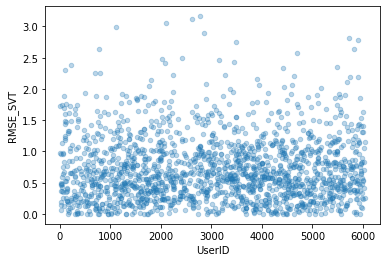

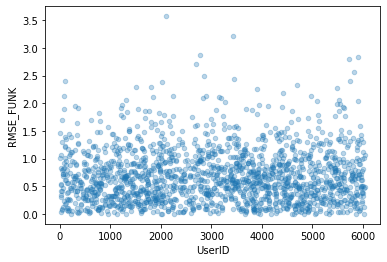

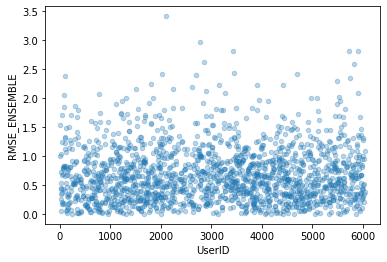

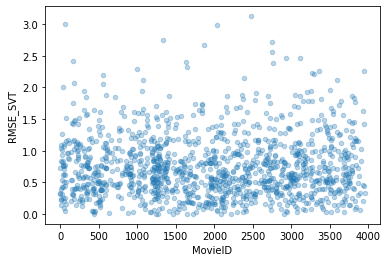

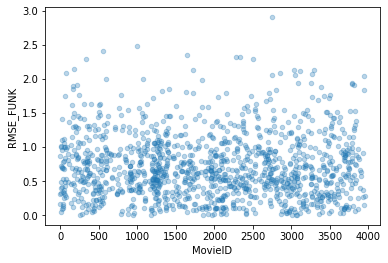

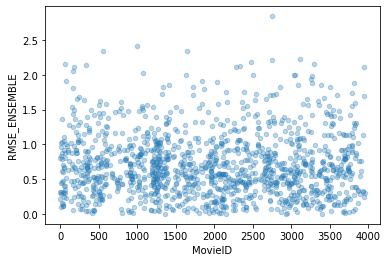

In [28]:
test_df['Pred_SVT'] = np.array(model1_test_pred)
test_df['Pred_FUNK'] = np.array(model2_test_pred)
test_df['Pred_ENSEMBLE'] = np.array(ensemble_test_pred)

def analyze_final(test_df, by_col):
    dic = {by_col:[], 'RMSE_SVT':[], 'RMSE_FUNK':[], 'RMSE_ENSEMBLE':[]}
    for u_id in np.unique(test_df[by_col]):
        by_df = test_df.loc[(test_df[by_col] == u_id)]
        pred1 = rmse(by_df['Rating'], by_df['Pred_SVT'])
        pred2 = rmse(by_df['Rating'], by_df['Pred_FUNK'])
        pred3 = rmse(by_df['Rating'], by_df['Pred_ENSEMBLE'])
        dic[by_col].append(u_id)
        dic['RMSE_SVT'].append(pred1)
        dic['RMSE_FUNK'].append(pred2)
        dic['RMSE_ENSEMBLE'].append(pred3)

    df = pd.DataFrame(dic)
    table= df.describe()
    table.drop(['count', 'min', 'max'], axis=0, inplace=True)
    table.drop([by_col], axis=1, inplace=True)
    display(table.style.format("{:.4f}"))
    print()

    df.plot(kind='scatter', x=by_col, y='RMSE_SVT', alpha=.3)
    df.plot(kind='scatter', x=by_col, y='RMSE_FUNK', alpha=.3)
    df.plot(kind='scatter', x=by_col, y='RMSE_ENSEMBLE', alpha=.3)

    
analyze_final(test_df, 'UserID')
analyze_final(test_df, 'MovieID')